### Testing Neural Network based Anomaly Detection on actual data

  This code reads PerfSONAR measured packet loss rates between a specified endpoint and all other endpoints in a selected time range. It tries to train neural network to distinguish measurements belonging to the timebin under investigation from measurements in a reference time period.

In [1]:
%matplotlib inline
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan

from time import time

import numpy as np
import pandas as pd
import random

import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)  
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

from pandas.tseries.offsets import *

Using TensorFlow backend.


#### parameters to set

In [2]:
n_series = 20 

start_date = '2017-05-13 00:00:00'
end_date = '2017-05-16 23:59:59'

# tuning parameters
ref = 24
sub = 1
chance = ref/(sub+ref)
cut = chance + (1-chance) * 0.05
print('chance:',chance, '\tcut:', cut)
ref = ref * Hour()
sub = sub * Hour()


srcSiteOWDServer = "128.142.223.247" # CERN site

# destSiteOWDServer = "193.109.172.188"  # pic site

chance: 0.96 	cut: 0.962


## get data from ES

we connect to elasticsearch, create query and execute scan. Query requires three things: data must be in the given timerange, must be measured by the selected endpoint and be packet loss data. Actual data access does not happen here but in the next cell.

In [3]:
es = Elasticsearch(['atlas-kibana.mwt2.org:9200'],timeout=60)
indices = "network_weather-2017.*"

start = pd.Timestamp(start_date)
end   = pd.Timestamp(end_date)

my_query = {
    'query': { 
       'bool':{
            'must':[
                    {'range': {'timestamp': {'gte': start.strftime('%Y%m%dT%H%M00Z'), 'lt': end.strftime('%Y%m%dT%H%M00Z')}}},
                    {'term': {'src': srcSiteOWDServer}},
#                     {'term': {'dest': destSiteOWDServer}},
                    {'term': {'_type': 'packet_loss_rate'}}
                    ]
               }
        }
}


scroll = scan(client=es, index=indices, query=my_query)

### Loading the data

This is the slowest part. It reads ~5k documents per second and will load 1M documents. Expect wait time of ~1 minutes. Actual time might vary depending on your connection and how busy is the Elasticsearch cluster. 

In [4]:
count = 0
allData={} # will be like this: {'dest_host':[[timestamp],[value]], ...} 
for res in scroll:
#     if count<2: print(res) 
    if not count%100000: print(count)
 #   if count>1000000: break
    dst = res['_source']['dest'] # old data - dest, new data - dest_host
    if dst not in allData: allData[dst]=[[],[]]
    allData[dst][0].append(res['_source']['timestamp'] )
    allData[dst][1].append(res['_source']['packet_loss'])
    
    count=count+1

dfs=[]
for dest,data in allData.items():
    ts=pd.to_datetime(data[0],unit='ms')
    df=pd.DataFrame({dest:data[1]}, index=ts )
    df.sort_index(inplace=True)
    df.index = df.index.map(lambda t: t.replace(second=0))
    df = df[~df.index.duplicated(keep='last')]
    dfs.append(df)
    #print(df.head(2))

print(count, "\nData loaded.")

0
100000
200000
300000
400000
495399 
Data loaded.


In [5]:
full_df = pd.concat(dfs, axis=1)

#### Puts together data from different links.

In [6]:
print(full_df.shape)
full_df.head()
#print(full_df.columns )

(5759, 73)


,200.136.80.20,192.41.230.59,206.12.9.2,163.1.5.210,134.158.103.10,81.180.86.38,129.215.213.70,159.93.225.211,193.205.76.76,188.185.224.217,...,195.19.226.144,159.93.229.151,131.225.205.12,206.12.24.251,85.122.31.74,192.41.236.31,192.12.15.26,146.83.90.7,158.195.14.26,192.170.227.160
2017-05-13 00:00:00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.000000,0.0,0.0
2017-05-13 00:01:00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.000000,0.0,0.0
2017-05-13 00:02:00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.000000,0.0,0.0
2017-05-13 00:03:00,0.0,0.0,0.0,0.0,0.001667,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.000000,0.0,0.0
2017-05-13 00:04:00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.001667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.018333,0.0,0.0


### preselecting X worst links but not really the worst

In [7]:
del full_df['134.158.73.243']
means=full_df.mean()
means.sort_values(ascending=False, inplace=True)
means=means[:n_series]
print(means)
df = full_df[means.index.tolist()]
df.shape

158.195.14.26      0.005346
192.54.207.250     0.002886
146.83.90.7        0.002350
130.209.239.124    0.001985
129.93.183.249     0.001601
129.107.255.29     0.001503
193.206.93.45      0.001437
193.239.180.211    0.001325
192.41.230.59      0.001127
131.169.98.30      0.000601
85.122.31.74       0.000589
159.93.225.211     0.000511
134.75.125.241     0.000465
192.231.127.41     0.000445
193.144.80.12      0.000396
159.93.229.151     0.000358
206.12.154.60      0.000331
206.12.9.2         0.000326
109.105.125.232    0.000316
200.136.80.20      0.000304
dtype: float64


(5759, 20)

#### plot timeseries

only a subset of all the links will be shown

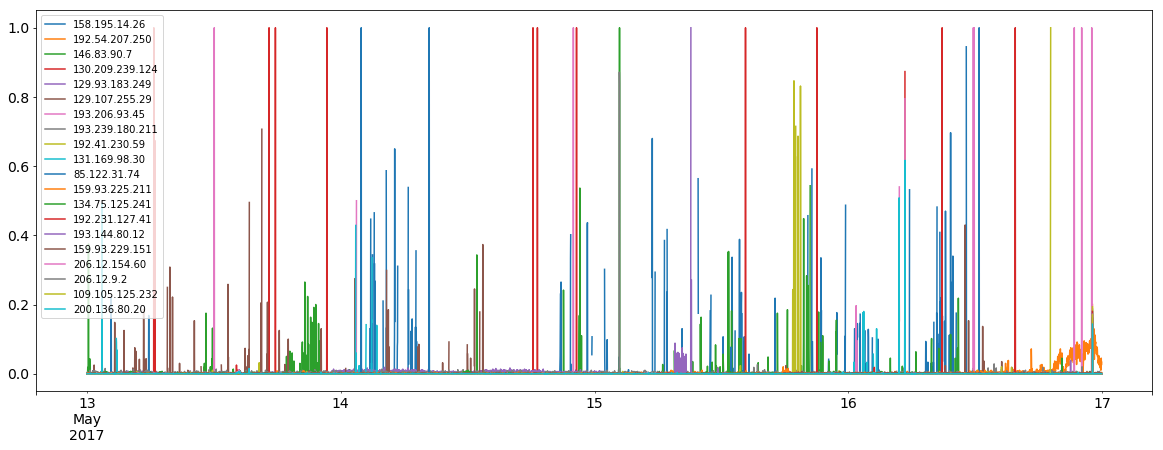

In [8]:
df.plot(figsize=(20,7))

### fix NANs and add accuracy column

In [9]:
# full_df.interpolate(method='nearest', axis=0, inplace=True)
df=df.fillna(0)
auc_df = pd.DataFrame(np.nan, index=df.index, columns=['accuracy'])

### create Network Model

only class is defined, no output is expected.

In [10]:
class ANN(object):
    def __init__(self, n_series):
        self.n_series = n_series
        self.df = None
        self.auc_df = None
        
        self.nn = Sequential()
        self.nn.add(Dense(units=n_series*2, input_shape=(n_series,), activation='relu' ))
#       self.nn.add(Dropout(0.5))
        self.nn.add(Dense(units=n_series*2, activation='relu'))
#       self.nn.add(Dropout(0.5))
        self.nn.add(Dense(units=1, activation='sigmoid'))
#       self.nn.compile(loss='hinge', optimizer='sgd', metrics=['binary_accuracy'])
#       self.nn.compile(loss='mse',optimizer='rmsprop', metrics=['accuracy'])
        self.nn.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy','binary_accuracy' ])
#         self.nn.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy','binary_accuracy' ])
#       self.nn.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['binary_accuracy'])
        self.nn.summary()
        
        self.initial_weights = self.nn.get_weights() 
    
    def set_data(self, df, auc_df):
        self.df = df
        self.auc_df = auc_df
    
    def plot_hist(self, hist):
        es=len(hist.history['loss'])
        x = np.linspace(0,es-1,es)
        plt.plot(x, hist.history['loss'], '--', linewidth=2, label='loss')
        plt.plot(x, hist.history['acc'], '-', linewidth=2, label='acc')
        plt.legend()
        plt.show()
    
    def check_for_anomaly(self,ref, sub, count):
    
        y_ref = pd.Series([0] * ref.shape[0])
        X_ref = ref
    
        y_sub = pd.Series([1] * sub.shape[0])
        X_sub = sub
        
        # separate Reference and Subject into Train and Test
        X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size=0.3)#, random_state=42)
        X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.3)#, random_state=42)
    
        # combine training ref and sub samples
        X_train = pd.concat([X_ref_train, X_sub_train])
        y_train = pd.concat([y_ref_train, y_sub_train])

        # combine testing ref and sub samples
        X_test = pd.concat([X_ref_test, X_sub_test])
        y_test = pd.concat([y_ref_test, y_sub_test])
    
        X_train = X_train.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)
    
        X_train_s, y_train_s = shuffle(X_train, y_train)
    
        self.nn.set_weights(self.initial_weights)
    
        hist = self.nn.fit(X_train_s.values, y_train_s.values, epochs=500, verbose=0, shuffle=True)#, batch_size=10)
        loss_and_metrics = self.nn.evaluate(X_test.values, y_test.values)#, batch_size=256)
        print(loss_and_metrics)
    
        if loss_and_metrics[1] > cut or not count%5: 
            self.plot_hist(hist)
        
        return scaled_accuracy(loss_and_metrics[1], ref.shape[0], sub.shape[0])
    
    
    def loop_over_intervals(self):
        lstart = self.df.index.min()
        lend = self.df.index.max()

        #round start 
        lstart.seconds=0
        lstart.minutes=0

        # loop over them
        ti = lstart + ref + sub
        count = 0
        while ti < lend + 1 * Minute():
            print(count)
            startt = time()
            ref_start = ti-ref-sub
            ref_end = ti-sub
            ref_df = self.df[(self.df.index >= ref_start) & (self.df.index < ref_end)]
            sub_df = self.df[(self.df.index >= ref_end) & (self.df.index < ti)]
#             print('ref:',ref_df.head())
#             print("sub:",sub_df.head())
            accuracy = self.check_for_anomaly(ref_df, sub_df, count)
            self.auc_df.loc[(self.auc_df.index >= ref_end) & (self.auc_df.index < ti), ['accuracy']]  = accuracy
            print('\n',ti,"\trefes:" , ref_df.shape, "\tsubjects:", sub_df.shape, '\tacc:', accuracy)
            ti = ti + sub
            print("took:", time()-startt)
            count = count + 1
            #if count>2: break    

#### functions

In [ ]:
def scaled_accuracy(accuracy, ref_samples, sub_samples):
    print(accuracy)
    chance = float(ref_samples)/(ref_samples+sub_samples)
    return (accuracy-chance)/(1-chance)


### Actually create the object, give it a data, run anomally detection. 
This part can take significant time. It takes 10-30 seconds per hour of data analyzed. Total number of steps will be equal to number of subject intervals in the period tested. For every 5th step and  intervals where anomaly has been detected ROC curve will be shown. 

In [ ]:
ann = ANN(n_series)
ann.set_data(df, auc_df)
ann.loop_over_intervals()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 41        
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________
0


### plot again full timeseries

In [ ]:
ndf=df.applymap(np.sqrt)
ax = ndf.plot(figsize=(20,7))
ax.set_xlim([pd.to_datetime('2017-05-13'),pd.to_datetime('2017-05-17')])
auc_df['Detected'] = 0
auc_df.loc[auc_df.accuracy>0.05, ['Detected']]=1
auc_df.accuracy.plot( ax=ax,color='b')
auc_df.Detected.plot( ax=ax, color='b', alpha=0.3)
ax.legend(loc='upper left')
ax.set_ylabel("sqrt(packet loss [%])", fontsize=14)
plt.show()
ax.get_figure().savefig('ANN_actual_data.png')

### shade regions where an anomaly has been dected

In [ ]:
fig, ax = plt.subplots(figsize=(20,7))
auc_df['Detected'] = 0
auc_df.loc[auc_df.accuracy>0.05, ['Detected']]=1
ax.plot( auc_df.accuracy,'black')
ax.fill( auc_df.Detected, 'b', alpha=0.3)
ax.legend(loc='upper left')
ax.set_xlim([pd.to_datetime('2017-05-13'),pd.to_datetime('2017-05-17')])
plt.show()
fig.savefig('ANN_shaded_actual_data.png')
